In [1]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications import DenseNet121
from sklearn.model_selection import train_test_split

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
x = np.load('/content/drive/MyDrive/AIT 736/ND/resized_images_ND.npy')
y = np.load('/content/drive/MyDrive/AIT 736/ND/labels_ND.npy')

# Perform train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=7)

# Create DenseNet base
input_shape = x_train.shape[1:]  # Assuming x_train is a numpy array of images
input_shape

(128, 128, 3)

In [8]:
print(x_train.shape)
print(x_test.shape)

(2200, 128, 128, 3)
(550, 128, 128, 3)


In [9]:
pip install vit-keras

In [10]:
pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 12.5 MB/s eta 0:00:00


In [11]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from vit_keras import vit

def create_ViT_base(input_shape):
    # Load ViT model without the top layer
    base_model = vit.build_model(image_size=input_shape[0], patch_size=16, num_layers=12, activation='linear',
                                 classes = 5, hidden_size =144, num_heads = 12, name = 'ViT_Dem', mlp_dim = 512, include_top=False)

    # Perform global average pooling
    x = base_model.output
    #x = GlobalAveragePooling2D()(x)

    # Add a dense layer with 125 sigmoid activated neurons
    x = Dense(125, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model

def create_classification_model(base_model, num_classes):
    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = True

    # Add a dense layer with softmax activation for classification
    x = Dense(num_classes, activation='softmax')(base_model.output)

    # Create the classification model
    model = Model(inputs=base_model.input, outputs=x)

    return model

base_model = create_ViT_base(input_shape)

num_classes = 5  # Change this to the number of classes in your classification task
classification_model = create_classification_model(base_model, num_classes)

classification_model.summary()


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 8, 8, 144)         110736    
                                                                 
 reshape (Reshape)           (None, 64, 144)           0         
                                                                 
 class_token (ClassToken)    (None, 65, 144)           144       
                                                                 
 Transformer/posembed_input  (None, 65, 144)           9360      
  (AddPositionEmbs)                                              
                                                                 
 Transformer/encoderblock_0  ((None, 65, 144),         232208    
  (TransformerBlock)          (None, 12, None, None)       

In [12]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
classification_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint("/content/drive/MyDrive/AIT 736/ND/vit-ND.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

# Train the model
history = classification_model.fit(x_train, y_train, epochs=25, batch_size=32, validation_data=(x_test, y_test), callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/25
69/69 [==============================] - ETA: 0s - loss: 1.6365 - accuracy: 0.1886
Epoch 1: val_loss improved from inf to 1.61359, saving model to /content/drive/MyDrive/AIT 736/ND/vit-ND.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


69/69 [==============================] - 64s 156ms/step - loss: 1.6365 - accuracy: 0.1886 - val_loss: 1.6136 - val_accuracy: 0.1873 - lr: 0.0010
Epoch 2/25
69/69 [==============================] - ETA: 0s - loss: 1.6275 - accuracy: 0.2032
Epoch 2: val_loss did not improve from 1.61359
69/69 [==============================] - 6s 83ms/step - loss: 1.6275 - accuracy: 0.2032 - val_loss: 1.6344 - val_accuracy: 0.1982 - lr: 0.0010
Epoch 3/25
69/69 [==============================] - ETA: 0s - loss: 1.6314 - accuracy: 0.1936
Epoch 3: val_loss did not improve from 1.61359
69/69 [==============================] - 7s 99ms/step - loss: 1.6314 - accuracy: 0.1936 - val_loss: 1.6197 - val_accuracy: 0.2127 - lr: 0.0010
Epoch 4/25
69/69 [==============================] - ETA: 0s - loss: 1.6242 - accuracy: 0.1873
Epoch 4: val_loss did not improve from 1.61359
69/69 [==============================] - 6s 83ms/step - loss: 1.6242 - accuracy: 0.1873 - val_loss: 1.6223 - val_accuracy: 0.1873 - lr: 0.0010
Epo

In [13]:
classification_model.load_weights("/content/drive/MyDrive/AIT 736/ND/vit-ND.h5")
classification_model.evaluate(x_test, y_test)

18/18 [==============================] - 1s 57ms/step - loss: 1.6095 - accuracy: 0.1964


[1.6094677448272705, 0.1963636428117752]

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Assuming classification_model.predict returns probabilities or predicted classes
y_pred = classification_model.predict(x_test)

# If y_pred contains probabilities, you may want to convert them to classes
# For binary classification:
# y_pred_classes = (y_pred > 0.5).astype(int)

# For multi-class classification with softmax output:
y_pred_classes = np.argmax(y_pred, axis=1)
from sklearn.metrics import classification_report

# Assuming y_pred_classes are predicted classes

# Generate classification report
report = classification_report(y_test, y_pred_classes, digits=5)

# Print the report
print("Classification Report:")
print(report)


18/18 [==============================] - 4s 36ms/step
Classification Report:
              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000       109
           1    0.00000   0.00000   0.00000       117
           2    0.00000   0.00000   0.00000       103
           3    0.00000   0.00000   0.00000       113
           4    0.19636   1.00000   0.32827       108

    accuracy                        0.19636       550
   macro avg    0.03927   0.20000   0.06565       550
weighted avg    0.03856   0.19636   0.06446       550



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


18/18 [==============================] - 3s 37ms/step


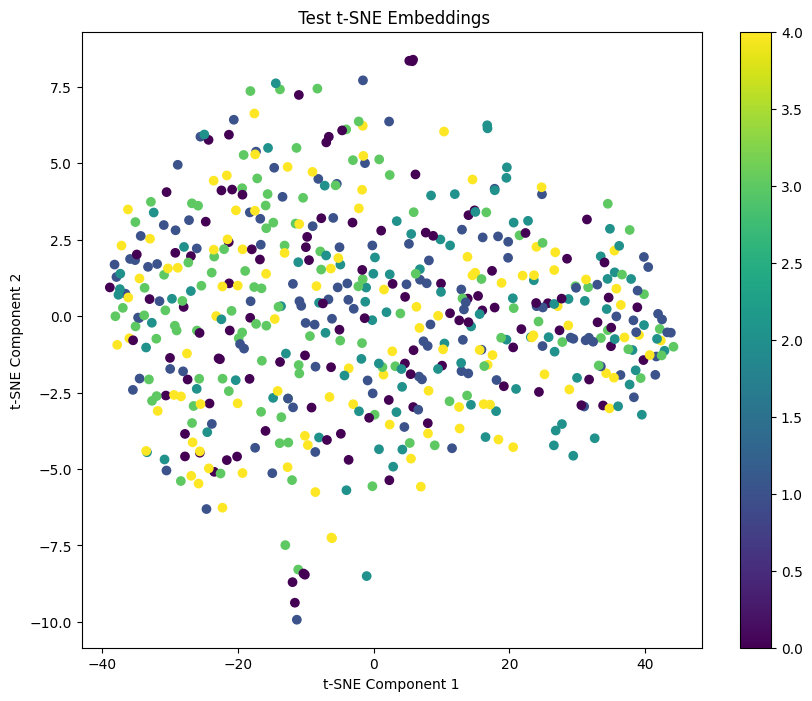

In [15]:
# Visualize t-SNE embeddings
# Assuming x_train_embed and x_test_embed are the embeddings obtained from the penultimate layer
tsne = TSNE(n_components=2, random_state=42)
x_embed = base_model.predict(x_test)  # Assuming x_test is your test data
x_tsne = tsne.fit_transform(x_embed)

# Plot t-SNE embeddings
plt.figure(figsize=(10, 8))
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_test, cmap='viridis')
plt.colorbar()
plt.title(' Test t-SNE Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


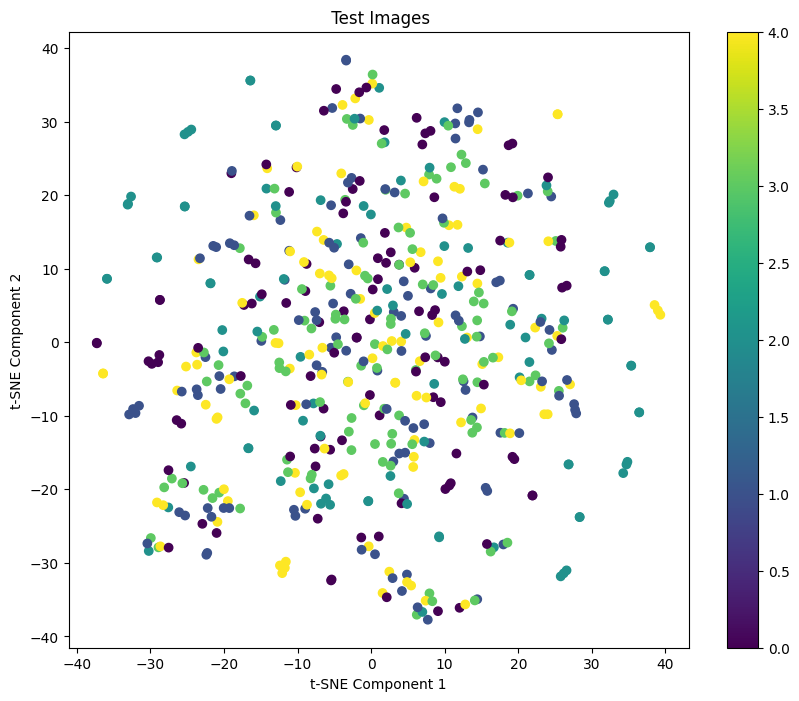

In [16]:
# Visualize t-SNE embeddings
# Assuming x_train_embed and x_test_embed are the embeddings obtained from the penultimate layer
x_test_flat = x_test.reshape((550, 128*128*3))
tsne = TSNE(n_components=2, random_state=42)
#x_embed = base_model.predict(x_test)  # Assuming x_test is your test data
x_tsne = tsne.fit_transform(x_test_flat)

# Plot t-SNE embeddings
plt.figure(figsize=(10, 8))
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_test, cmap='viridis')
plt.colorbar()
plt.title(' Test Images')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


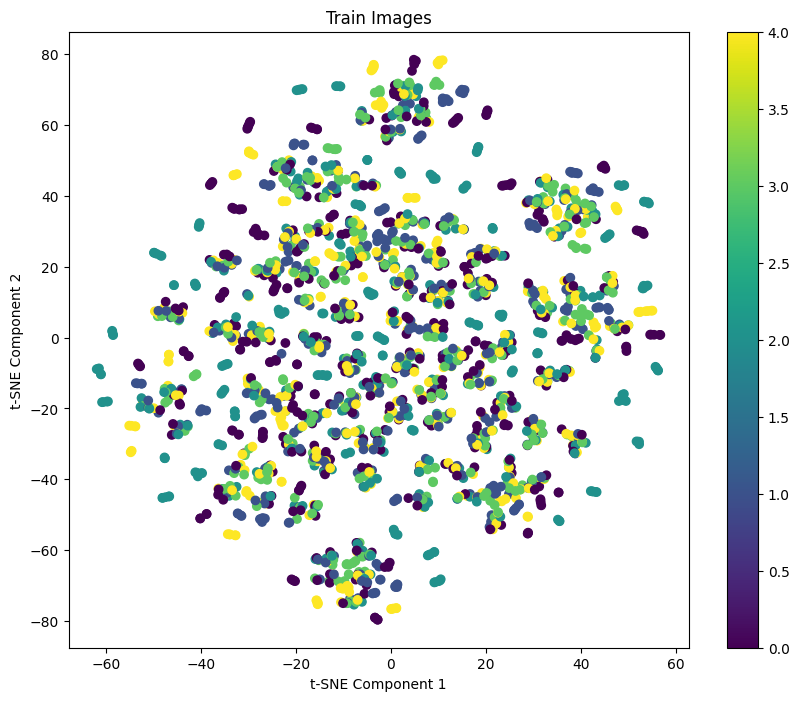

In [17]:
# Visualize t-SNE embeddings
# Assuming x_train_embed and x_train_embed are the embeddings obtained from the penultimate layer
x_train_flat = x_train.reshape((2200, 128*128*3))
tsne = TSNE(n_components=2, random_state=42)
#x_embed = base_model.predict(x_train)  # Assuming x_train is your train data
x_tsne = tsne.fit_transform(x_train_flat)

# Plot t-SNE embeddings
plt.figure(figsize=(10, 8))
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_train, cmap='viridis')
plt.colorbar()
plt.title('Train Images')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


69/69 [==============================] - 2s 33ms/step


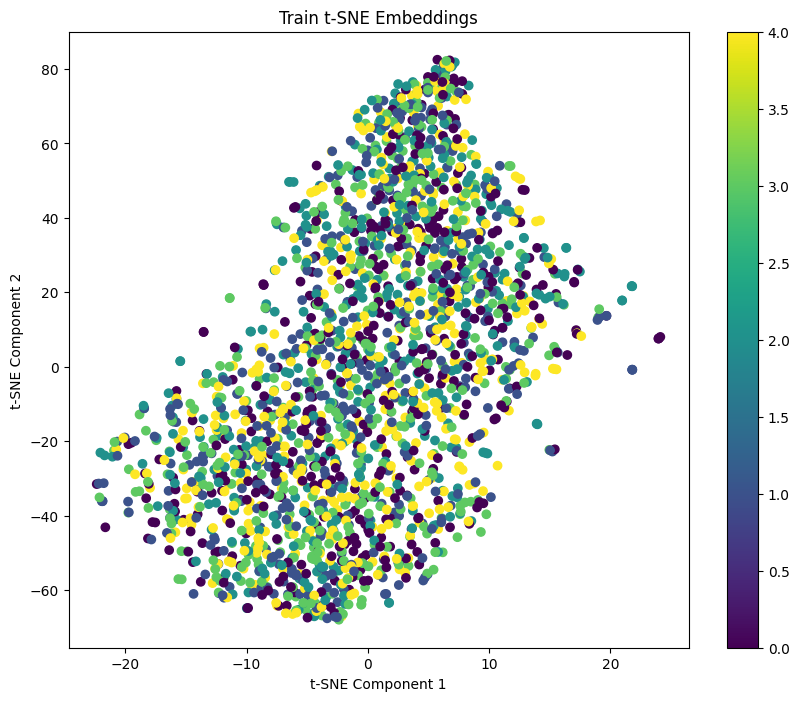

In [18]:
# Visualize t-SNE embeddings
# Assuming x_train_embed and x_train_embed are the embeddings obtained from the penultimate layer
tsne = TSNE(n_components=2, random_state=42)
x_embed = base_model.predict(x_train)  # Assuming x_train is your train data
x_tsne = tsne.fit_transform(x_embed)

# Plot t-SNE embeddings
plt.figure(figsize=(10, 8))
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_train, cmap='viridis')
plt.colorbar()
plt.title('Train t-SNE Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


<h1>E-Mixup

In [19]:
xtest_emb = base_model.predict(x_test)
xtrain_emb = base_model.predict(x_train)

69/69 [==============================] - 3s 45ms/step


In [20]:
import keras
y_test_o = keras.utils.to_categorical(y_test)
y_train_o = keras.utils.to_categorical(y_train)
print(y_train_o.shape)
print(y_test_o.shape)

(2200, 5)
(550, 5)


In [21]:
def mixup(xt, yt, mf):
  alp = 0.2
  xaug = []
  yaug = []
  for k in range(0,xt.shape[0]):
    cnt = 0
    for cnt in range(0,mf-1):
      lbd = np.random.beta(alp,alp)
      yks = np.random.randint(xt.shape[0])
      kdash = xt[yks]
      ydash = yt[yks]
      kdash1 = xt[k]
      ydash1 = yt[k]
      xaug1 = kdash1*lbd + kdash*(1-lbd)
      yaug1 = ydash1*lbd + ydash*(1-lbd)
      xaug.append(xaug1)
      yaug.append(yaug1)
  xs2 = np.asarray(xaug)
  ys2 = np.asarray(yaug)
  x1 = np.concatenate((xt,xs2))
  y1 = np.concatenate((yt,ys2))
  return x1,y1

In [22]:
xtrain_emb.shape

(2200, 125)

In [23]:
xtt, ytt = mixup(xtrain_emb,y_train_o,3)
xtt.shape

(6600, 125)

In [24]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
import tensorflow as tf

Classifier_model = Sequential()
#add model layers
Classifier_model.Input = (125,)

Classifier_model.add(Dense(512,activation='relu'))
Classifier_model.add(Dense(512,activation='relu'))

Classifier_model.add(Dense(5, activation='softmax'))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
Classifier_model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
Classifier_model.fit(xtt, ytt,epochs=25, validation_data=(xtest_emb, y_test_o))

Epoch 1/25
207/207 [==============================] - 2s 4ms/step - loss: 1.6184 - accuracy: 0.2064 - val_loss: 1.6141 - val_accuracy: 0.1873
Epoch 2/25
207/207 [==============================] - 1s 3ms/step - loss: 1.6100 - accuracy: 0.2070 - val_loss: 1.6104 - val_accuracy: 0.1873
Epoch 3/25
207/207 [==============================] - 1s 3ms/step - loss: 1.6095 - accuracy: 0.2052 - val_loss: 1.6105 - val_accuracy: 0.1982
Epoch 4/25
207/207 [==============================] - 1s 3ms/step - loss: 1.6095 - accuracy: 0.2021 - val_loss: 1.6103 - val_accuracy: 0.1873
Epoch 5/25
207/207 [==============================] - 1s 3ms/step - loss: 1.6094 - accuracy: 0.2055 - val_loss: 1.6102 - val_accuracy: 0.1982
Epoch 6/25
207/207 [==============================] - 1s 3ms/step - loss: 1.6094 - accuracy: 0.2009 - val_loss: 1.6106 - val_accuracy: 0.1982
Epoch 7/25
207/207 [==============================] - 1s 3ms/step - loss: 1.6094 - accuracy: 0.1958 - val_loss: 1.6105 - val_accuracy: 0.1982
Epoch 

In [25]:
Classifier_model.evaluate(xtest_emb, y_test_o)

18/18 [==============================] - 0s 2ms/step - loss: 1.6104 - accuracy: 0.1982


[1.610351800918579, 0.19818182289600372]

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Assuming Classifier_model.predict returns probabilities or predicted classes
y_pred = Classifier_model.predict(xtest_emb)

# If y_pred contains probabilities, you may want to convert them to classes
# For binary classification:
# y_pred_classes = (y_pred > 0.5).astype(int)
# For multi-class classification with softmax output:
y_pred_classes = np.argmax(y_pred, axis=1)
from sklearn.metrics import classification_report

# Assuming y_pred_classes are predicted classes

# Generate classification report
report = classification_report(y_test, y_pred_classes, digits=5)

# Print the report
print("Classification Report:")
print(report)



18/18 [==============================] - 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0    0.19818   1.00000   0.33080       109
           1    0.00000   0.00000   0.00000       117
           2    0.00000   0.00000   0.00000       103
           3    0.00000   0.00000   0.00000       113
           4    0.00000   0.00000   0.00000       108

    accuracy                        0.19818       550
   macro avg    0.03964   0.20000   0.06616       550
weighted avg    0.03928   0.19818   0.06556       550



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


E-Stitchup

In [27]:
import numpy as np

def stichup(xt, yt, mf):
    alp = 0.2
    xaug = []
    yaug = []
    for k in range(xt.shape[0]):
        for _ in range(mf-1):  # Renamed loop counter to avoid confusion with loop index
            lbd = np.random.beta(alp, alp)
            yks = np.random.randint(xt.shape[0])
            kdash = xt[yks]  # Accessing rows of xt directly
            ydash = yt[yks]  # Accessing corresponding y value
            kdash1 = xt[k]    # Accessing rows of xt directly
            ydash1 = yt[k]    # Accessing corresponding y value
            lbd_stch = int(xt.shape[1] * lbd)
            reff_stich = np.zeros(xt.shape[1])
            for i in range(lbd_stch):
                index_stich = np.random.randint(xt.shape[1])
                reff_stich[index_stich] = 1
            xaug1 = np.zeros(xt.shape[1])  # Initialize as numpy array
            for i in range(len(reff_stich)):
                if reff_stich[i] == 0:
                    xaug1[i] = kdash[i]
                else:
                    xaug1[i] = kdash1[i]
            yaug1 = ydash1 * lbd + ydash * (1 - lbd)
            xaug.append(xaug1)
            yaug.append(yaug1)
    xs2 = np.asarray(xaug)
    ys2 = np.asarray(yaug)
    x1 = np.concatenate((xt, xs2))
    y1 = np.concatenate((yt, ys2))
    return x1, y1


In [28]:
xtt, ytt = stichup(xtrain_emb,y_train_o,3)
xtt.shape

(6600, 125)

In [29]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
import tensorflow as tf

Classifier_model = Sequential()
#add model layers
Classifier_model.Input = (125,)

Classifier_model.add(Dense(512,activation='relu'))
Classifier_model.add(Dense(512,activation='relu'))

Classifier_model.add(Dense(5, activation='softmax'))
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
Classifier_model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
Classifier_model.fit(xtt, ytt,epochs=25, validation_data=(xtest_emb, y_test_o))

Epoch 1/25
207/207 [==============================] - 2s 5ms/step - loss: 1.6219 - accuracy: 0.1973 - val_loss: 1.6104 - val_accuracy: 0.1964
Epoch 2/25
207/207 [==============================] - 1s 3ms/step - loss: 1.6102 - accuracy: 0.2039 - val_loss: 1.6099 - val_accuracy: 0.1982
Epoch 3/25
207/207 [==============================] - 1s 4ms/step - loss: 1.6096 - accuracy: 0.1992 - val_loss: 1.6101 - val_accuracy: 0.1873
Epoch 4/25
207/207 [==============================] - 1s 4ms/step - loss: 1.6096 - accuracy: 0.1938 - val_loss: 1.6099 - val_accuracy: 0.1873
Epoch 5/25
207/207 [==============================] - 1s 3ms/step - loss: 1.6096 - accuracy: 0.2053 - val_loss: 1.6100 - val_accuracy: 0.1964
Epoch 6/25
207/207 [==============================] - 1s 3ms/step - loss: 1.6095 - accuracy: 0.1989 - val_loss: 1.6099 - val_accuracy: 0.1964
Epoch 7/25
207/207 [==============================] - 1s 3ms/step - loss: 1.6095 - accuracy: 0.2056 - val_loss: 1.6099 - val_accuracy: 0.1964
Epoch 

In [30]:
Classifier_model.evaluate(xtest_emb, y_test_o)

18/18 [==============================] - 0s 2ms/step - loss: 1.6100 - accuracy: 0.1964


[1.610024333000183, 0.1963636428117752]

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Assuming Classifier_model.predict returns probabilities or predicted classes
y_pred = Classifier_model.predict(xtest_emb)

# If y_pred contains probabilities, you may want to convert them to classes
# For binary classification:
# y_pred_classes = (y_pred > 0.5).astype(int)
# For multi-class classification with softmax output:
y_pred_classes = np.argmax(y_pred, axis=1)
from sklearn.metrics import classification_report

# Assuming y_pred_classes are predicted classes

# Generate classification report
report = classification_report(y_test, y_pred_classes, digits=5)

# Print the report
print("Classification Report:")
print(report)



18/18 [==============================] - 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000       109
           1    0.00000   0.00000   0.00000       117
           2    0.00000   0.00000   0.00000       103
           3    0.00000   0.00000   0.00000       113
           4    0.19636   1.00000   0.32827       108

    accuracy                        0.19636       550
   macro avg    0.03927   0.20000   0.06565       550
weighted avg    0.03856   0.19636   0.06446       550



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
